# UNet In Action

## Biomedical Image Segmentation

An implementation of the UNet to a medical image dataset to identify cell's nuclei. The dataset used for this implementation is taken from a kaggle competition @ [2018 Data Science Bowl - Find the nuclei in divergent images to advance medical discovery](https://www.kaggle.com/c/data-science-bowl-2018/).

### Why Automate Nuclei Identification?

*Identifying the cells’ nuclei is the starting point for most analyses because most of the human body’s 30 trillion cells contain a nucleus full of DNA, the genetic code that programs each cell. Identifying nuclei allows researchers to identify each individual cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work. By automating the process of nuclei identification, allows for more efficient drug testing, shortening the time it takes for each new drug to come to market.* (Ref - [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018/))

### Original Paper<br>
The original paper can be accesss @ https://arxiv.org/abs/1505.04597

### Why Unet? <br>
*UNet, a convolutional neural network dedicated for biomedical image segmentation, was first designed and applied in 2015. In general the usecases for a typical convolutional neural network focuses on image classification tasks, where
the output to an image is a single class label, however in biomedical image visual tasks, it requires not only to distinguish whether there is a medical condition, but also to localize the area of infection i.e., a class label is supposed to be assigned to each pixel.*

### UNet Architecture <br>
**The Unet netowrk model has 3 parts:**

- The Contracting/Downsampling Path.
- Bottleneck Block.
- The Expansive/Upsampling Path.

**Contracting Path:**<br>
It consists of two 3x3 unpadded convolutions each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. After each downsampling operation, the number of feature channels are doubled.

**Bottleneck Block:**<br>
The bottleneck block connects the contracting and the expansive paths. This block performs two unpadded convolutions each with 1024 filters and prepares for the expansive path.

**Expansive Path:**<br>
Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) using transposed convolutions, a concatenation with the correspondingly feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. Transposed convolution is an upsampling technique to expand the size of images.

**Skip Connections:**<br>
The skip connections from the contracting path are concatenated with the corresponding feature maps in the expansive path. These skip connections provide higher resolution features to better localize and learn representations from the input image. They also help in recovering any spatial information that could have been lost during downsampling

**Final Layer:**<br>
At the final layer a 1x1 convolution is used to map each (64 component) feature vector to the desired number of classes.

***The entire network consists of a total of 23 convolotional layers.***


### UNet Network Diagram <br>

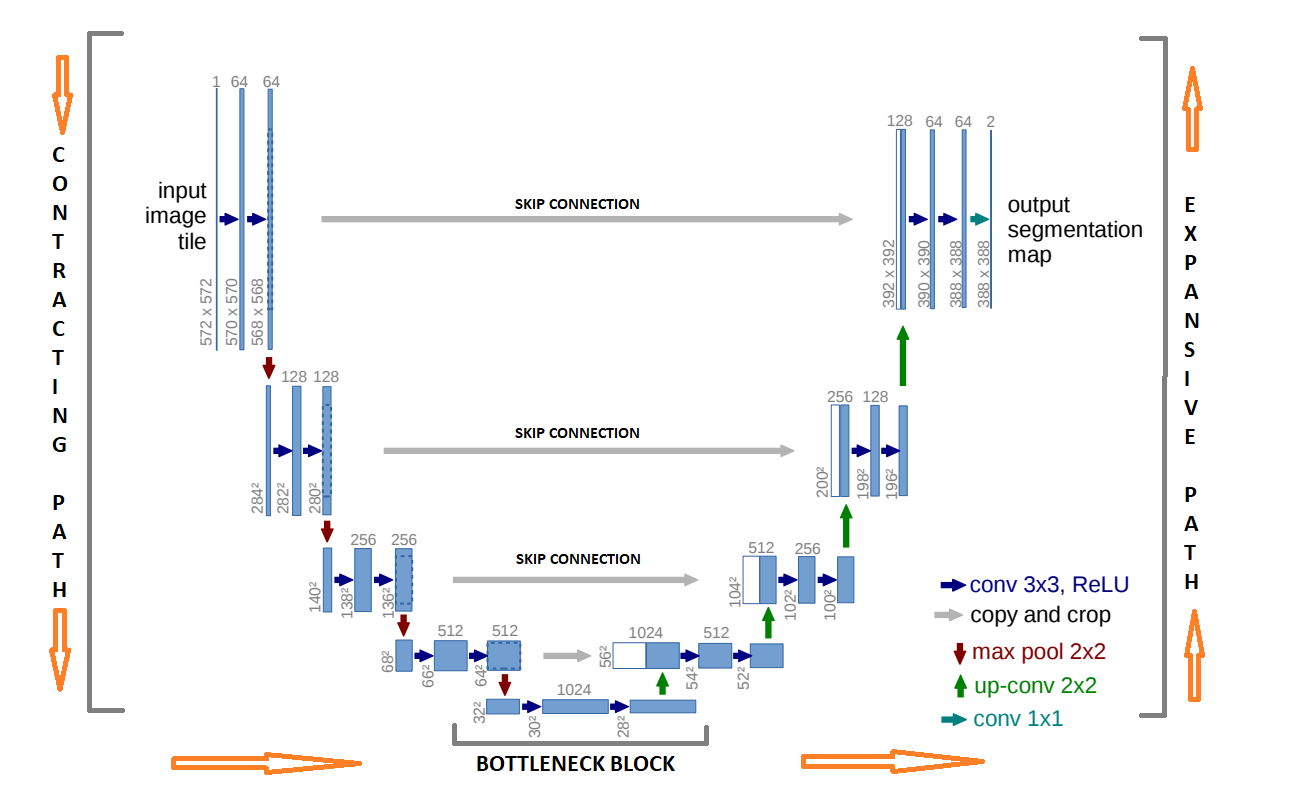

Image Reference - https://arxiv.org/pdf/1505.04597.pdf

### Original Paper Implementation
The original UNet model's implementation as described in the [paper](https://arxiv.org/pdf/1505.04597.pdf) can be found @ [UNet - Biomedical_Segmentation](https://github.com/sauravmishra1710/U-Net---Biomedical-Image-Segmentation/blob/main/UNet%20-%20Biomedical_Segmentation.ipynb)

### Applying UNet to a Realtime Dataset

#### Import Required Libraries and Utilities

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from UNetDataGenerator import  NucleiDataGenerator
from Unet import Unet

import datetime
import json
import tensorflow as tf
import tensorflow.keras.backend as K
import random

import matplotlib.pyplot as plt
from IPython.display import clear_output

2025-05-10 12:49:19.930155: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 12:49:19.939129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746874159.949411  279919 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746874159.952249  279919 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 12:49:19.962523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

#### Define Implementation details, Dataset criteria and Model hyper parameters

In [3]:
### TOTAL IMÁGENES

def count_images_in_directory(directory, extensions=[".jpg", ".png", ".jpeg"]):
    image_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.endswith(ext) for ext in extensions):
                image_count += 1
    return image_count

image_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles"

total_images = count_images_in_directory(image_dir)

print(f"Total de imágenes encontradas: {total_images}")

Total de imágenes encontradas: 644


In [10]:
image_size = 256
image_channels = 3
epochs = 3000
batch_size = 8


In [ ]:
image_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles"
image_files = []

for root, dirs, files in os.walk(image_dir):
    if root.endswith("images"):  
        for filename in files:
            if filename.endswith(".jpg") or filename.endswith(".png"):  
                image_files.append(os.path.join(root, filename))  

print("Lista de imágenes:", image_files)


Lista de imágenes: ['/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00069C/images/00069C.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00047C/images/00047C.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00115C/images/00115C.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00101C/images/00101C.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00084C/images/00084C.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00017C/images/00017C.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00059C/images/00059C.png', '/home/anna/TFM/TFM-Radiomica/U-Net

#### Define Reusable Methods

#### Define Train, Test and Validation sets

In [ ]:
def count_images_in_directory(directory, extensions=[".jpg", ".png", ".jpeg"]):
    image_files = []  
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.endswith(ext) for ext in extensions):
                image_files.append(os.path.join(root, file))
    return image_files


image_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles"
image_files = count_images_in_directory(image_dir)

total_images = len(image_files)
print(f"Total de imágenes encontradas: {total_images}")


train_data_size = int(total_images)  # 70% para entrenamiento
#validation_data_size = int(total_images * 0.15)  # 15% para validación
#test_data_size = total_images - (train_data_size + validation_data_size)  # El resto para prueba

training_data_ids = image_files[:train_data_size]
#validation_data_ids = image_files[train_data_size:train_data_size + validation_data_size]
#testing_data_ids = image_files[train_data_size + validation_data_size:]

print("\nImágenes de entrenamiento:")
for img in training_data_ids:
    print(img)

#print("\nImágenes de validación:")
#for img in validation_data_ids:
    #print(img)

#print("\nImágenes de prueba:")
#for img in testing_data_ids:
    #print(img)

# Verificamos que no haya imágenes duplicadas entre los conjuntos
train_set = set(training_data_ids)
print(f"Tamaño del conjunto de entrenamiento: {len(training_data_ids)} imágenes")
#validation_set = set(validation_data_ids)
#test_set = set(testing_data_ids)

#overlap_train_validation = train_set.intersection(validation_set)
#overlap_train_test = train_set.intersection(test_set)
#overlap_validation_test = validation_set.intersection(test_set)

#if overlap_train_validation or overlap_train_test or overlap_validation_test:
    #print("\n¡Error! Hay imágenes duplicadas entre los conjuntos.")
#else:
    #print("\nNo hay imágenes duplicadas entre los conjuntos.")




Total de imágenes encontradas: 644

Imágenes de entrenamiento:
/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00069C/masks/00069C_1.png
/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00069C/images/00069C.png
/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00047C/masks/00047C_1.png
/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00047C/images/00047C.png
/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00115C/masks/00115C_1.png
/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00115C/images/00115C.png
/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00101C/masks/00101C_1.png
/home/ann

In [11]:
# get the ids of the images.
# os.walk yields a 3-tuple (dirpath, dirnames, filenames). We need the directory names here.
# the name for parent of parent directory where the image is located and the name of the image are same.
# an example directory breakup is shown below -
# - data-science-bowl-2018/
#      - stage1_train/
#          - abc
#             - image
#                  - abc
#             - mask
image_ids = next(os.walk(image_dir))[1]

#testing_data_ids = image_files[:test_data_size]
#validation_data_ids = image_files[:validation_data_size]
training_data_ids = image_files[:train_data_size]

#print("Imágenes de prueba:", (testing_data_ids))
#print("Imágenes de validación:", (validation_data_ids))
print("Imágenes de entrenamiento:", (training_data_ids))

Imágenes de entrenamiento: ['/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00069C/masks/00069C_1.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00069C/images/00069C.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00047C/masks/00047C_1.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00047C/images/00047C.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00115C/masks/00115C_1.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00115C/images/00115C.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00101C/masks/00101C_1.png', '/home/anna/TFM/TFM-Rad

#### Sample Data Visualization

In [ ]:
masks_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles"
masks_files = []

for root, dirs, files in os.walk(masks_dir):
    if root.endswith("masks"):  
        for filename in files:
            if filename.endswith(".jpg") or filename.endswith(".png"):  
                masks_files.append(os.path.join(root, filename))  

print("Lista de máscaras:", masks_files)



Lista de máscaras: ['/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00069C/masks/00069C_1.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00047C/masks/00047C_1.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00115C/masks/00115C_1.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00101C/masks/00101C_1.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00084C/masks/00084C_1.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00017C/masks/00017C_1.png', '/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles/00059C/masks/00059C_1.png', '/home/anna/TFM/TFM-Radiomic

In [13]:
temp_data_generator = NucleiDataGenerator(image_ids = training_data_ids, 
                                          img_path = image_dir, 
                                          batch_size = batch_size, 
                                          image_size = image_size)

# get one batch of data
images, masks = temp_data_generator.__getitem__(0)
print("Batch Dimension Details:", images.shape, masks.shape)

Batch Dimension Details: (8, 256, 256, 3) (8, 256, 256, 1)


In [14]:
def VisualizeImageAndMask(image, mask, prediction_img = None):
    
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
    fig.suptitle('Image & Mask(s)', fontsize = 15)
    fig.subplots_adjust(top = 1.15)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image)
    setTitleAndRemoveTicks(ax, 'Microscopic\nImage')
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(mask, (image_size, image_size)), cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nMask')
    
    if prediction_img is not None:
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(np.reshape(prediction_img, (image_size, image_size)), cmap = "gray")
        setTitleAndRemoveTicks(ax, 'Predicted\nMask')
    
def setTitleAndRemoveTicks(axes, title):

    axes.title.set_text(title)
    
    axes.set_xticks([])
    axes.set_yticks([])

In [ ]:
VisualizeImageAndMask(image = images[1], mask = masks[1])

In [ ]:
VisualizeImageAndMask(image = images[2], mask = masks[2])

In [ ]:
VisualizeImageAndMask(image = images[6], mask = masks[6])

In [ ]:
VisualizeImageAndMask(image = images[3], mask = masks[3])

In [15]:
temp_data_generator = None

### Model Training and Validation

#### Create UNet Model 

In [16]:
# Evitar aleatoriedad

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
unet = Unet(input_shape = (image_size, image_size, image_channels), 
            filters = [32, 64, 128, 256],
            padding = "same")

# call the build netowrk API to build the network.
model = unet.Build_UNetwork()

_____ Coeficiente Dice _______

$Dice=\frac{2\cdot |A∩B|}{|A|+|B|}$ 

* A es la máscara real
* B es la máscara predicha
* ∣A∩B∣ es la intersección entre las dos máscaras (los píxeles que coinciden).
* ∣A∣+∣B∣ es la suma de los tamaños de ambas máscaras.

$Dice Loss= 1-Dice Coefficent$

In [13]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss=dice_loss, 
              metrics=[dice_coefficient])

model.summary()


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ dropout_3[0][0] 

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

#### Data Generators

In [ ]:
train_gen = NucleiDataGenerator(image_ids = training_data_ids, 
                                img_path = image_dir, 
                                image_size = image_size, 
                                batch_size = batch_size,
                                shuffle=True, 
                                augment=True)

#valid_gen = NucleiDataGenerator(
    #image_ids=validation_data_ids,
    #img_path=image_dir,
    #image_size=image_size,
    #batch_size=batch_size,
    #shuffle=False
#)

#test_gen = NucleiDataGenerator(
    #image_ids=testing_data_ids,
    #img_path=image_dir,
    #image_size=image_size,
    #batch_size=batch_size,
    #shuffle=False
#)


train_steps = int(np.ceil(len(training_data_ids) / batch_size))  # Metemos int por si len(training_data_ids) % batch_size != 0, entonces el último lote se pierde, lo que puede causar que el generador se quede sin datos.
#test_steps = int(np.ceil(len(testing_data_ids) / batch_size))
#valid_steps = int(np.ceil(len(validation_data_ids) / batch_size))

In [16]:
import imgaug.augmenters as iaa
import numpy as np

if not hasattr(np, 'bool'):
    np.bool = np.bool_


images, masks = next(iter(train_gen))
print(images.shape, masks.shape)  

print(np.min(masks), np.max(masks))

(8, 256, 256, 3) (8, 256, 256, 1)
0.0 1.0


/tmp/ipykernel_279919/1975878495.py:4: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


#### Model Training

In [ ]:
# Con validación

class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch = []
        self.loss = []
        self.val_loss = []
        self.dice = []
        self.val_dice = []
        self.test_dice = []
        self._smoothing = 0.8  

    def _smooth(self, values):
        smoothed = []
        for v in values:
            if smoothed:
                smoothed.append(smoothed[-1] * self._smoothing + v * (1 - self._smoothing))
            else:
                smoothed.append(v)
        return smoothed

    def on_epoch_end(self, epoch, logs=None):
        self.epoch.append(epoch)
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.dice.append(logs['dice_coefficient'])
        self.val_dice.append(logs['val_dice_coefficient'])

        # Evaluación del test dice
        results = self.model.evaluate(self.model.test_gen, steps=self.model.test_steps, verbose=0)
        self.test_dice.append(results[1])
        print(f"🔍 Epoch {epoch+1} - Test Dice Coefficient: {results[1]:.4f}")

        # Grafica
        clear_output(wait=True)
        plt.figure(figsize=(14, 5))

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch, self._smooth(self.loss), label='Train Loss')
        plt.plot(self.epoch, self._smooth(self.val_loss), label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss (Suavizada)')
        plt.legend()

        # Dice
        plt.subplot(1, 2, 2)
        plt.plot(self.epoch, self._smooth(self.dice), label='Train Dice')
        plt.plot(self.epoch, self._smooth(self.val_dice), label='Val Dice')
        plt.plot(self.epoch, self._smooth(self.test_dice), label='Test Dice')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Coefficient')
        plt.title('Dice Coefficient (Suavizada)')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [27]:
# Sin validación

class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch = []
        self.loss = []
        self.dice = []
        self._smoothing = 0.8

    def _smooth(self, values):
        smoothed = []
        for v in values:
            if smoothed:
                smoothed.append(smoothed[-1] * self._smoothing + v * (1 - self._smoothing))
            else:
                smoothed.append(v)
        return smoothed

    def on_epoch_end(self, epoch, logs=None):
        self.epoch.append(epoch)
        self.loss.append(logs['loss'])
        self.dice.append(logs['dice_coefficient'])

        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch, self._smooth(self.loss), label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train Loss (Smoothed)')
        plt.legend()

        # Dice
        plt.subplot(1, 2, 2)
        plt.plot(self.epoch, self._smooth(self.dice), label='Dice Coefficient')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Coefficient')
        plt.title('Train Dice Coefficient (Smoothed)')
        plt.legend()

        plt.tight_layout()
        plt.show()


Bajamos el learning rate a mitad

In [28]:
tf.keras.callbacks.ReduceLROnPlateau

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      
    factor=0.5,              
    patience=80,             
    min_lr=1e-9,           
    verbose=1                
)

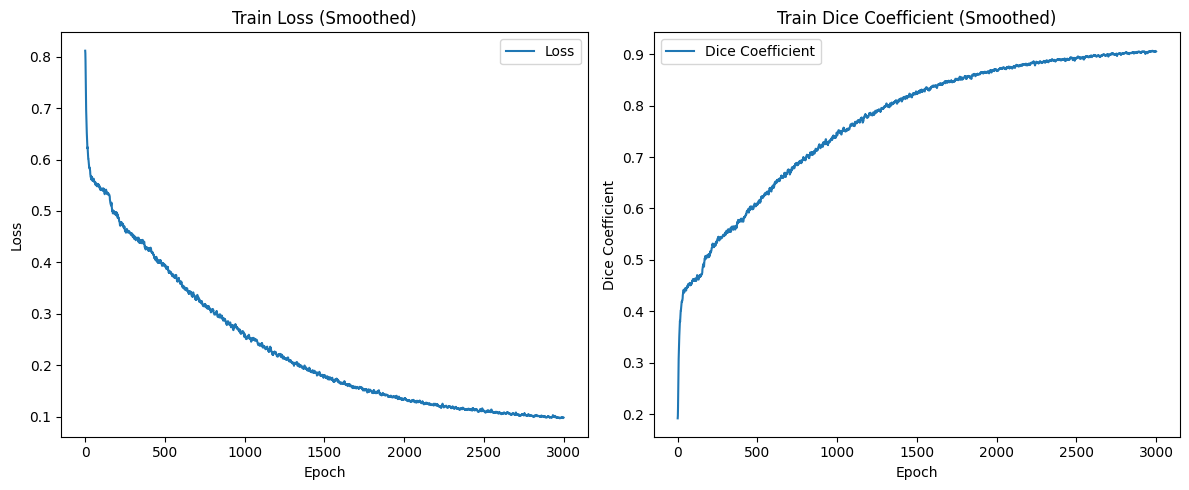

81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 380ms/step - dice_coefficient: 0.9017 - loss: 0.1014


In [29]:
# Sin validación

live_plot = LivePlotCallback()

# Entrenamiento
history = model.fit(
    train_gen, 
    steps_per_epoch=train_steps, 
    epochs=epochs,
    callbacks=[live_plot]
)

In [ ]:
# Con validación

model.test_gen = test_gen
model.test_steps = test_steps

live_plot = LivePlotCallback()

# Entrenamiento
history = model.fit(
    train_gen, 
    validation_data=valid_gen, 
    steps_per_epoch=train_steps, 
    validation_steps=valid_steps, 
    epochs=epochs,
    callbacks=[live_plot]
)

### Model Testing and Prediction Visualizations

In [30]:
# get the test set images
test_images, test_masks = test_gen.__getitem__(1)
predicted_masks = model.predict(test_images)

predicted_masks = predicted_masks > 0.5

NameError: name 'test_gen' is not defined

#### Viz 1

In [ ]:
VisualizeImageAndMask(image = test_images[1], mask = test_masks[1], prediction_img = predicted_masks[1])

#### Viz 2

In [ ]:
VisualizeImageAndMask(image = test_images[2], mask = test_masks[2], prediction_img = predicted_masks[2])

#### Viz 3

In [ ]:
VisualizeImageAndMask(image = test_images[4], mask = test_masks[4], prediction_img = predicted_masks[4])

In [ ]:
## Guardar MODELO

# 1. Carpeta con timestamp

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_dir = f"entrenamientos/{current_time}"
os.makedirs(save_dir, exist_ok=True)

# 2. Guardar modelo completo

model_path = os.path.join(save_dir, "unet_model.keras")
model.save(model_path)

# 3. Guardar historial de entrenamiento

history_path = os.path.join(save_dir, "training_history.pkl")
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

# 4. Guardar configuración usada

config = {
    "input_shape": model.input_shape[1:],
    "filters": unet.filters,
    "padding": unet.padding,
    "epochs": epochs,
    "batch_size": batch_size,
    "image_size": image_size,
    "image_channels": image_channels,
    "train_data_size": len(training_data_ids),
    #"val_data_size": len(validation_data_ids),
    #"test_data_size": len(testing_data_ids),
    "optimizer": "Adam",
    "learning_rate": 1e-5,
    "loss_function": "dice_loss",
    "metrics": ["dice_coefficient"]
}
config_path = os.path.join(save_dir, "config.pkl")
with open(config_path, "wb") as f:
    pickle.dump(config, f)

# 5. Guardar gráficas de métricas (loss + dice)

def plot_and_save_metric(metric_name, train_values, val_values, test_values=None, ylabel="", title=""):
    plt.figure()
    plt.plot(train_values, label=f"Train {metric_name}")
    plt.plot(val_values, label=f"Val {metric_name}")
    if test_values:
        plt.plot(test_values, label=f"Test {metric_name}")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{metric_name.lower()}_curve.png"))
    plt.close()

# Usamos las métricas del callback personalizado

plot_and_save_metric("Loss", live_plot.loss, live_plot.val_loss, ylabel="Loss", title="Training and Validation Loss")
plot_and_save_metric("Dice", live_plot.dice, live_plot.val_dice, live_plot.test_dice, ylabel="Dice Coefficient", title="Dice Coefficient (Train, Val, Test)")


In [36]:
# DICE

# Evaluamos en el conjunto de entrenamiento
train_dice = model.evaluate(train_gen, steps=train_steps)[1]  # Índice 1 porque devuelve [loss, dice_coefficient]

# Evaluamos en el conjunto de validación
#val_dice = model.evaluate(valid_gen, steps=valid_steps)[1]

# Evaluamos en el conjunto de prueba
#test_dice = model.evaluate(test_gen, steps=int(np.ceil(len(testing_data_ids) / batch_size)))[1]

print(f"Dice Coefficient - Train: {train_dice:.4f}")
      #Validation: {val_dice:.4f}, Test: {test_dice:.4f}")


81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - dice_coefficient: 0.6506 - loss: 0.3525
Dice Coefficient - Train: 0.6526
